In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# For temporary display of existing figures
from IPython.display import Image, display

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)
rename_vars = {'P_O': 'Precip\n(Ocean)',
               'E_O': 'Evap\n(Ocean)',
               'P_L': 'Precip\n(Land)',
               'ET_L': 'Evap\n(Land)',
               'R_L': 'Runoff\n(Land)',
               'C_A': 'Convergence\n(Land+Ocean)',
               'C_O': 'Convergence\n(Ocean)',
               'C_L': 'Convergence\n(Land)',
              }
rename_index = {'rasm_cpl_era_monthly_ts': 'RASM (ERA)',
                'rasm_cpl_cfsr_monthly_ts': 'RASM (CFSR)',
                'rasm_cpl_era_monthly_ts_rsi': 'RASM (RSI)',
                'rasm_cpl_era_monthly_ts_rsh': 'RASM (RSH)',
                'merra_monthly_ts1': 'MERRA',
                'era_monthly_ts3': 'ERA-I',
               }

In [3]:
re = 6.37122e6
rho = 1.000e3
days_per_year = 365.
seconds_per_year = days_per_year * 86400.
mm_per_m = 1000.
m_per_km = 1000.
m3_to_km3 = 1 / m_per_km**3
kg_to_km3 = m3_to_km3 / rho

In [4]:
rasm_sims = ['$RASM_{CONTROL}$', '$RASM_{RSI}$', '$RASM_{RSH}$']

In [5]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_lnd_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'
ncfiles['rasm_ocn_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc'

ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc'
ncfiles['$RASM_{RSI}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/cpl/monthly_mean_timeseries/R1010RBRbrsi01a.cpl.hmm.197909-201412.nc'
ncfiles['$RASM_{RSH}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/cpl/monthly_mean_timeseries/R1010RBRbrsh01a.cpl.hmm.197909-201412.nc'
ncfiles['era_monthly_ts3'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc'
ncfiles['merra_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc'
ncfiles['cru_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/cru_ts3.21/cru_ts3.21.1901.2012_wr50a.nc'
ncfiles['sheffield_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/sheffield2006/sheffield2006_wr50a.mm.nc'
ncfiles['adam_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/adam2003/adam2003_wr50a.mm.nc'

start='1990-01-01'
end='2014-12-31'

ncdata = {}
for k, v in ncfiles.items():
    try:
        ncdata[k] = xr.open_dataset(v)
#         print(k, ncdata[k].dims)       
    except Exception as e:
        print(k, '<---unable to decode time!', e)

# Rename variables in datasets as necessary
name_dicts = {'era_monthly_ts3': {'tp': 'Precipitation',
                                  'e': 'Evaporation',
                                  'ro': 'Runoff'},
              'sheffield_monthly_ts':{'prcp': 'Precipitation'},
              'merra_monthly_ts1': {'prectot': 'Precipitation',
                                    'runoff': 'Runoff',
                                    'baseflow': 'Baseflow',
                                    'shland': 'Senht',
                                    'lhland': 'Latht',
                                    'snomas': 'Swq',
                                    'evland': 'Evaporation',
                                    'lwland': 'Lwnet',
                                    'swland': 'Swnet'},
              'cru_monthly_ts': {'pre': 'Precipitation'},
              'adam_monthly_ts': {'Precip': 'Precipitation'},
              'rasm_lnd_masks': {'ni': 'x', 'nj': 'y'},
              'rasm_domain': {'ni': 'x', 'nj': 'y'},
             }

for sim in rasm_sims:
    name_dicts[sim] = {'a2xavg_nx': 'x', 'a2xavg_ny': 'y', 
                       'l2xavg_nx': 'x', 'l2xavg_ny': 'y',
                       'x2aavg_nx': 'x', 'x2aavg_ny': 'y',
                       'x2lavg_nx': 'x', 'x2lavg_ny': 'y',
                       'x2aavg_Faxx_evap': 'Evaporation',
                       'l2xavg_Flrl_rofliq': 'Runoff'}

for k, v in ncdata.items():
    if k in name_dicts:
        v.rename(name_dicts[k], inplace=True)
    print(k, v.dims)
        

# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)

ncdata['merra_monthly_ts1'] = ncdata['merra_monthly_ts1'].isel(
    time=np.argsort(ncdata['merra_monthly_ts1'].time))

sheffield_monthly_ts Frozen(SortedKeysDict({'z': 1, 'x': 275, 'time': 720, 'y': 205, 'nv4': 4}))
rasm_ocn_masks Frozen(SortedKeysDict({'x': 275, 'y': 205}))
cru_monthly_ts Frozen(SortedKeysDict({'x': 275, 'time': 1344, 'y': 205, 'nv4': 4}))
$RASM_{RSI}$ Frozen(SortedKeysDict({'x': 275, 'time': 424, 'y': 205}))
$RASM_{RSH}$ Frozen(SortedKeysDict({'x': 275, 'time': 424, 'y': 205}))
rasm_lnd_masks Frozen(SortedKeysDict({'nv': 4, 'x': 275, 'y': 205}))
era_monthly_ts3 Frozen(SortedKeysDict({'x': 275, 'time': 433, 'y': 205, 'nv4': 4}))
adam_monthly_ts Frozen(SortedKeysDict({'x': 275, 'time': 718, 'y': 205, 'nv4': 4}))
$RASM_{CONTROL}$ Frozen(SortedKeysDict({'x': 275, 'time': 424, 'y': 205}))
rasm_domain Frozen(SortedKeysDict({'nv': 4, 'x': 275, 'y': 205}))
merra_monthly_ts1 Frozen(SortedKeysDict({'x': 275, 'time': 420, 'y': 205, 'nv4': 4}))


In [6]:
lnd_mask_keys = ['mask_rof_to_centralarctic', 'mask_rof_to_kara', 'mask_rof_to_barents']

lnd_mask = ncdata['rasm_lnd_masks'][lnd_mask_keys].to_array().sum(dim='variable')
lnd_mask = lnd_mask.clip(0., 1.)

ocn_mask_keys = ['mask_centralarctic', 'mask_kara', 'mask_barents']

ocn_mask = ncdata['rasm_ocn_masks'][ocn_mask_keys].to_array().sum(dim='variable')
ocn_mask = ocn_mask.clip(0., 1.)

full_mask = lnd_mask + ocn_mask
full_mask = full_mask.clip(0., 1.)

all_ones_mask = full_mask.copy()
all_ones_mask[:] = 1.
else_mask = all_ones_mask - full_mask


In [7]:
# Add variables or adjust units of datasets if ncessary

# RASM
re = 6.37122e6
ncdata['rasm_domain']['area'] *= re * re  # m2

for sim in rasm_sims:
    ncdata[sim]['Precipitation'] = (ncdata[sim]['a2xavg_Faxa_rainc'] 
                                    + ncdata[sim]['a2xavg_Faxa_rainl'] 
                                    + ncdata[sim]['a2xavg_Faxa_snowc'] 
                                    + ncdata[sim]['a2xavg_Faxa_snowl'])
    
# ERA-Interim
for var in ('Runoff', 'Precipitation'):
    ncdata['era_monthly_ts3'][var] *= 1000.
ncdata['era_monthly_ts3'] = ncdata['era_monthly_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_monthly_ts3']['Evaporation'] *= 1000.
ncdata['era_monthly_ts3']['Runoff'] = ncdata['era_monthly_ts3']['Runoff']
ncdata['era_monthly_ts3'] = ncdata['era_monthly_ts3'].drop(['nv4', 'xc_bnds', 'yc_bnds'])

# MERRA
ncdata['merra_monthly_ts1']['Precipitation'] *= 86400 
ncdata['merra_monthly_ts1']['Runoff'] *= 86400 
ncdata['merra_monthly_ts1']['Baseflow'] *= 86400 
ncdata['merra_monthly_ts1']['Evaporation'] *= -1 * 86400 
ncdata['merra_monthly_ts1']['Runoff'] = ncdata['merra_monthly_ts1']['Runoff'] + ncdata['merra_monthly_ts1']['Baseflow']
ncdata['merra_monthly_ts1'] = ncdata['merra_monthly_ts1'].drop(['Baseflow'])

reanalyses = ['era_monthly_ts3', 'merra_monthly_ts1']

In [8]:
def mask_to_vol(var, mask, domain, units='kg m-2 s-1', ndays=365):
    '''
    var (units: kg m-2 s-1) and mask are numpy arrays, domain is a xarray dataset
    
    returns volume in km3
    '''
    if units == 'kg m-2 s-1':
        units_mult = kg_to_km3 * ndays * 86400
    elif units == 'mm d-1':
        units_mult = ndays * m3_to_km3 / mm_per_m
    
    return (var * domain['area'] * mask).sum() * units_mult
    

In [9]:
def empty_df():
    df = pd.DataFrame()
    df['P_O'] = [np.nan]
    df['E_O'] = [np.nan]
    df['P_L'] = [np.nan]
    df['ET_L'] = [np.nan]
    df['R_L'] = [np.nan]
    df['C_A'] = [np.nan]
    
    return df

def get_summary(data, var, mask, **kwargs):
    
    try:
        return mask_to_vol(data[var], mask, ncdata['rasm_domain'], **kwargs)
    except:
        return np.nan
    
    return val

In [10]:
rasm_sims + reanalyses

['$RASM_{CONTROL}$',
 '$RASM_{RSI}$',
 '$RASM_{RSH}$',
 'era_monthly_ts3',
 'merra_monthly_ts1']

In [11]:
#  domain mask
summary = OrderedDict()
for sim in rasm_sims + reanalyses:
    print(sim)
    summary[sim] = empty_df()
    ds = ncdata[sim][['Precipitation', 'Evaporation']]
    
    if 'rasm' in sim:
        units = 'kg m-2 s-1'
    else:
        units = 'mm d-1'
        
    cpl_annual_mean = annual_mean(ds.sel(time=slice(start, end)), calendar='noleap')
    cpl_annual_mean['C_A'] = cpl_annual_mean['Precipitation'] + cpl_annual_mean['Evaporation']
    summary[sim]['C_A'][0] = get_summary(cpl_annual_mean, 'C_A', all_ones_mask, units=units)
        
    print(summary[sim])

$RASM_{CONTROL}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.232832
$RASM_{RSI}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.233085
$RASM_{RSH}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.233733
era_monthly_ts3
   P_O  E_O  P_L  ET_L  R_L           C_A
0  NaN  NaN  NaN   NaN  NaN  17601.298788
merra_monthly_ts1
   P_O  E_O  P_L  ET_L  R_L           C_A
0  NaN  NaN  NaN   NaN  NaN  59926.043596


In [12]:
#  else mask
summary = OrderedDict()
for sim in rasm_sims + reanalyses:
    print(sim)
    summary[sim] = empty_df()
    ds = ncdata[sim][['Precipitation', 'Evaporation']]
   
    if 'rasm' in sim:
        units = 'kg m-2 s-1'
    else:
        units = 'mm d-1'

    cpl_annual_mean = annual_mean(ds.sel(time=slice(start, end)), calendar='noleap')

    try:
        cpl_annual_mean['C_A'] = cpl_annual_mean['Precipitation']
        cpl_annual_mean['C_A'] += cpl_annual_mean['Evaporation']
        summary[sim]['C_A'][0] = get_summary(cpl_annual_mean, 'C_A', else_mask, units=units)
    except:
        summary[sim]['C_A'][0] = np.nan
        
    print(summary[sim])

$RASM_{CONTROL}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.173584
$RASM_{RSI}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.173745
$RASM_{RSH}$
   P_O  E_O  P_L  ET_L  R_L       C_A
0  NaN  NaN  NaN   NaN  NaN  0.174568
era_monthly_ts3
   P_O  E_O  P_L  ET_L  R_L           C_A
0  NaN  NaN  NaN   NaN  NaN  12873.676571
merra_monthly_ts1
   P_O  E_O  P_L  ET_L  R_L           C_A
0  NaN  NaN  NaN   NaN  NaN  56049.321279


$RASM_{CONTROL}$
$RASM_{RSI}$
$RASM_{RSH}$
era_monthly_ts3
merra_monthly_ts1
ADAM
SHEFFIELD


,Precip (Ocean),Evap (Ocean),Convergence (Ocean),Precip (Land),Evap (Land),Runoff (Land),Convergence (Land),Convergence (Land+Ocean),dS_L
$RASM_{CONTROL}$,2649.960117,576.875983,2073.084135,8304.917589,5258.739781,3043.803449,3046.177808,5119.042544,2.374360
$RASM_{RSI}$,2699.911544,646.392762,2053.518781,8340.392270,5266.712359,3075.207378,3073.679912,5126.980699,1.527467
$RASM_{RSH}$,2773.240304,802.414489,1970.825814,8455.043026,5313.858150,3144.727714,3141.184876,5111.796403,3.542838
ERA-I,2899.805097,1168.690483,1731.114614,7809.444082,4812.743500,3740.932753,2996.700582,4727.622217,744.232171
MERRA,2758.615669,314.135279,2444.480390,7323.643042,5891.273803,1409.331772,1432.369240,3876.722317,23.037468
ADAM,NaN,NaN,NaN,7254.742010,NaN,NaN,NaN,NaN,NaN
SHEFFIELD,1955.178558,NaN,NaN,6289.999545,NaN,NaN,NaN,NaN,NaN
SERREZE,NaN,NaN,NaN,NaN,NaN,3200.000000,NaN,NaN,NaN


,Precip (Ocean),Evap (Ocean),Convergence (Ocean),Precip (Land),Evap (Land),Runoff (Land),Convergence (Land),Convergence (Land+Ocean),dS_L
$RASM_{RSI}$,1.884988,12.050559,-0.943780,0.427153,0.151606,1.031733,0.902840,0.155071,-35.668272
$RASM_{RSH}$,4.652153,39.096533,-4.932666,1.807669,1.048129,3.315729,3.118894,-0.141553,49.212356


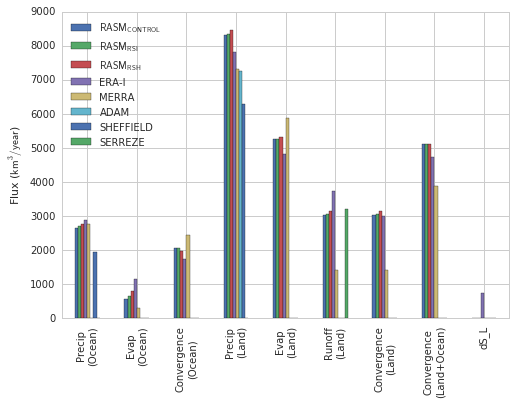

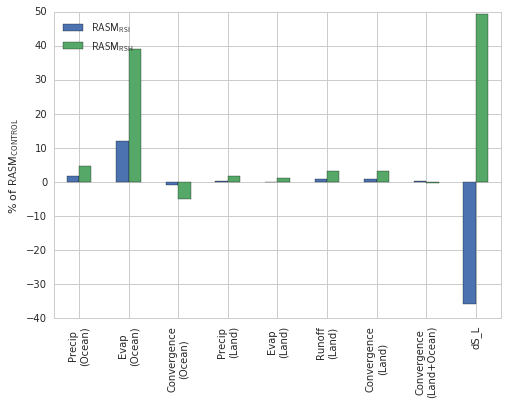

In [13]:
# land / ocean masks

columns = ['P_O', 'E_O', 'P_L', 'ET_L', 'R_L', 'C_A']
index = rasm_sims + ['era_monthly_ts3', 'merra_monthly_ts1', 'ADAM', 'SHEFFIELD', 'SERREZE']

# Models
summary = pd.DataFrame(data=np.nan, index=index, columns=['P_O', 'E_O', 'C_O', 'P_L', 'ET_L', 'R_L', 'C_L',  'C_A'])
for sim in rasm_sims + reanalyses:
    print(sim)
    ds = ncdata[sim][['Precipitation', 'Evaporation', 'Runoff']]
   
    if 'RASM' in sim:
        units = 'kg m-2 s-1'
    else:
        units = 'mm d-1'

    data = annual_mean(ds.sel(time=slice(start, end)), calendar='noleap')
    data['C_A'] = data['Precipitation'] + data['Evaporation']

    summary.ix[sim]['P_L'] = get_summary(data, 'Precipitation', lnd_mask, units=units)
    summary.ix[sim]['ET_L'] = get_summary(data, 'Evaporation', lnd_mask, units=units)
    summary.ix[sim]['R_L'] = get_summary(data, 'Runoff', lnd_mask, units=units)
    summary.ix[sim]['P_O'] = get_summary(data, 'Precipitation', ocn_mask, units=units)
    summary.ix[sim]['E_O'] = get_summary(data, 'Evaporation', ocn_mask, units=units)
    summary.ix[sim]['C_A'] = get_summary(data, 'C_A', full_mask, units=units)
        
# Adam Precip
sim = 'ADAM'
print(sim)
kwargs = dict(units='mm d-1', ndays=365.25)
adam_annual_mean = annual_mean(ncdata['adam_monthly_ts'].sel(time=slice(start, end)), calendar='standard')
summary.ix[sim]['P_L'] = get_summary(adam_annual_mean, 'Precipitation', lnd_mask, **kwargs)

# Sheffield Precip 
sim = 'SHEFFIELD'
print(sim)
kwargs = dict(units='kg m-2 s-1', ndays=365.25)
sheffield_annual_mean = annual_mean(ncdata['sheffield_monthly_ts'].sel(time=slice(start, end)), calendar='standard').squeeze()
summary.ix[sim]['P_L'] = get_summary(sheffield_annual_mean, 'Precipitation', lnd_mask, **kwargs)
summary.ix[sim]['P_O'] = get_summary(sheffield_annual_mean, 'Precipitation', ocn_mask, **kwargs)

# Serreze runoff
summary.ix['SERREZE']['R_L'] = 3200

summary['C_L'] = summary['P_L'] + summary['ET_L'] 
summary['C_O'] = summary['P_O'] + summary['E_O'] 
summary['dS_L'] = summary['P_L'] + summary['ET_L'] - summary['R_L']

df = summary.abs()
df_rename = df.rename(columns=rename_vars, index=rename_index)
display(df_rename)

# Make bar plot
sns.set_style('whitegrid')
index = summary.keys()

plt.figure(figsize=(8, 4))
df_rename.T.plot(kind='bar', legend=False)
plt.legend(loc=2)
plt.ylabel('Flux ($km^3/year$)')

rasm_df = df_rename.ix[rasm_sims[1:]].subtract(df_rename.ix[rasm_sims[0]]) / df_rename.ix[rasm_sims[0]].abs() * 100

display(rasm_df)

rasm_df.T.plot(kind='bar', legend=False)
plt.legend(loc=2)
plt.ylabel('%% of %s' % rasm_sims[0])

$RASM_{CONTROL}$
$RASM_{RSI}$
$RASM_{RSH}$
era_monthly_ts3
merra_monthly_ts1


,Precip (Ocean),Evap (Ocean),Convergence (Ocean),Precip (Land),Evap (Land),Runoff (Land),Convergence (Land),Convergence (Land+Ocean),dS_L
$RASM_{CONTROL}$,598.954241,204.756435,394.197805,1481.466257,46.690480,116.873071,1434.775776,1828.922406,1317.902706
$RASM_{RSI}$,617.955222,231.105290,386.849931,1497.489335,46.999874,118.747584,1450.489462,1837.288248,1331.741878
$RASM_{RSH}$,664.873843,310.422111,354.451732,1520.688080,46.438405,126.650110,1474.249675,1828.649654,1347.599565
ERA-I,741.173973,378.578498,362.595474,1565.753128,235.016486,848.043021,1330.736642,1693.284421,482.693621
MERRA,687.492238,6.933404,680.558834,1499.456511,210.109827,82.470422,1289.346684,1418.878232,1206.876262


,Precip (Ocean),Evap (Ocean),Convergence (Ocean),Precip (Land),Evap (Land),Runoff (Land),Convergence (Land),Convergence (Land+Ocean),dS_L
$RASM_{RSI}$,3.172359,12.868389,-1.864007,1.081569,0.662647,1.603888,1.095201,0.457419,1.050091
$RASM_{RSH}$,11.005783,51.605546,-10.082774,2.647500,-0.539886,8.365520,2.751224,-0.014913,2.253342


,Precip (Ocean),Evap (Ocean),Convergence (Ocean),Precip (Land),Evap (Land),Runoff (Land),Convergence (Land),Convergence (Land+Ocean),dS_L
$RASM_{RSI}$,19.000981,26.348855,-7.347874,16.023079,0.309393,1.874513,15.713685,8.365842,13.839172
$RASM_{RSH}$,65.919603,105.665676,-39.746074,39.221824,-0.252075,9.777040,39.473899,-0.272752,29.696859


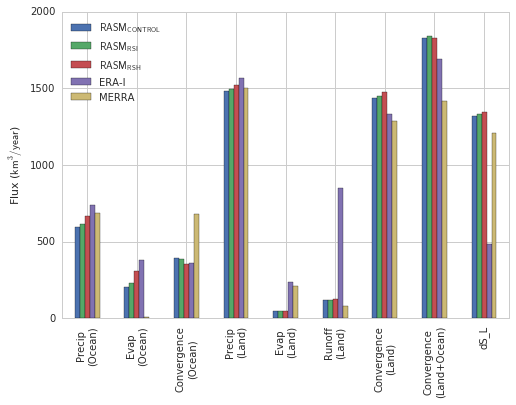

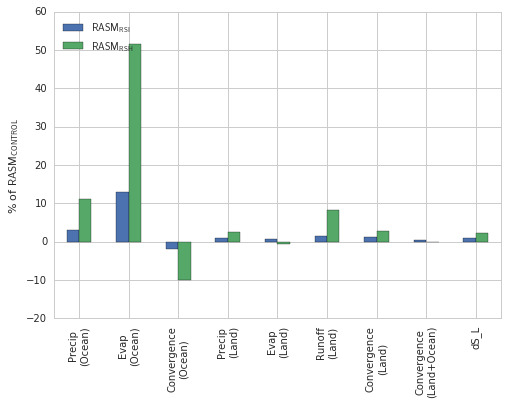

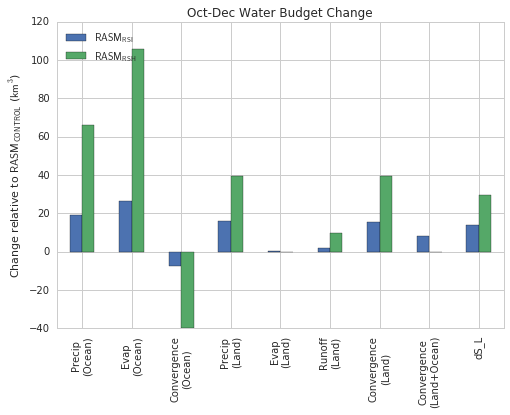

In [29]:
days = 92 # oct-dec

# land / ocean masks

columns = ['P_O', 'E_O', 'C_O', 'P_L', 'ET_L', 'R_L', 'C_L', 'C_A']
index = rasm_sims + ['era_monthly_ts3', 'merra_monthly_ts1']



# Models
summary = pd.DataFrame(data=np.nan, index=index, columns=columns)
for sim in rasm_sims + reanalyses:
    print(sim)
    ds = ncdata[sim][['Precipitation', 'Evaporation', 'Runoff']]
   
    if 'RASM' in sim:
        units = 'kg m-2 s-1'
    else:
        units = 'mm d-1'

    data = ds.sel(time=ds.indexes['time'].month > 9).resample('AS', how='mean', dim='time').mean(dim='time')
    data['C_A'] = data['Precipitation'] + data['Evaporation']

    summary.ix[sim]['P_L'] = get_summary(data, 'Precipitation', lnd_mask, units=units, ndays=days)
    summary.ix[sim]['ET_L'] = get_summary(data, 'Evaporation', lnd_mask, units=units, ndays=days)
    summary.ix[sim]['R_L'] = get_summary(data, 'Runoff', lnd_mask, units=units, ndays=days)
    summary.ix[sim]['P_O'] = get_summary(data, 'Precipitation', ocn_mask, units=units, ndays=days)
    summary.ix[sim]['E_O'] = get_summary(data, 'Evaporation', ocn_mask, units=units, ndays=days)
    summary.ix[sim]['C_A'] = get_summary(data, 'C_A', full_mask, units=units, ndays=days)
        
summary['C_L'] = summary['P_L'] + summary['ET_L'] 
summary['C_O'] = summary['P_O'] + summary['E_O'] 
summary['dS_L'] = summary['P_L'] + summary['ET_L'] - summary['R_L']


df = summary.abs()
df_rename = df.rename(columns=rename_vars, index=rename_index)
display(df_rename)

# Make bar plot
sns.set_style('whitegrid')
index = summary.keys()

plt.figure(figsize=(8, 4))
df_rename.T.plot(kind='bar', legend=False)
plt.legend(loc=2)
plt.ylabel('Flux ($km^3/year$)')

# percent change
rasm_df = df_rename.ix[rasm_sims[1:]].subtract(df_rename.ix[rasm_sims[0]]) / df_rename.ix[rasm_sims[0]].abs() * 100
display(rasm_df)
rasm_df.T.plot(kind='bar', legend=False)
plt.legend(loc=2)
plt.ylabel('%% of %s' % rasm_sims[0])

# absolute change
rasm_df = df_rename.ix[rasm_sims[1:]].subtract(df_rename.ix[rasm_sims[0]])
display(rasm_df)
rasm_df.T.plot(kind='bar', legend=False)
plt.legend(loc=2)
plt.ylabel('Change relative to %s ($km^3$)' % rasm_sims[0])
plt.title('Oct-Dec Water Budget Change')

In [15]:
df2 = df_rename
df2['Dataset'] = df_rename.index
melt = pd.melt(df2, 'Dataset')

In [16]:
flatui = ["#000000", "#000000", "#ec3125", "#4092c5", "#58b95b", "#ab66aa", "#f7941e"]

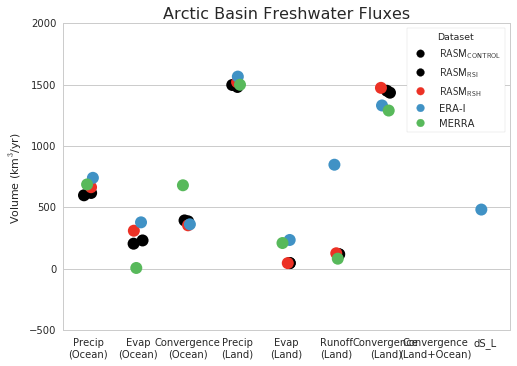

In [17]:
sns.set_style("whitegrid", {'legend.frameon': True})

sns.stripplot(x="variable", y="value", data=melt,
              hue='Dataset', palette=flatui,
              jitter=True, edgecolor="grey", split=False, size=12)

plt.xlabel('')
plt.ylabel('Volume (km$^3$/yr)')
# plt.ylim([0, 9000])
plt.title('Arctic Basin Freshwater Fluxes', fontsize=16)

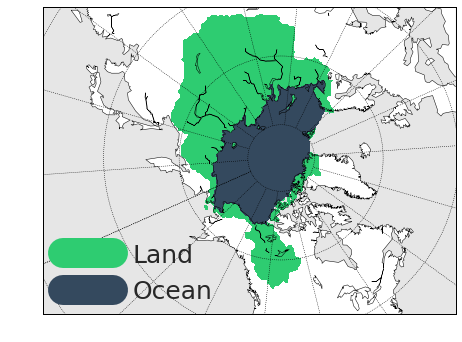

In [18]:
sns.set_style("white")
fig, ax = plt.subplots()

wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
wr50a_map.m.drawmapboundary(fill_color=fill_color)
wr50a_map.m.fillcontinents(color='white', zorder=0)
wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi, np.ma.masked_where(lnd_mask <= 0, lnd_mask), colors=["#2ecc71", "#2ecc71"])
wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi, np.ma.masked_where(ocn_mask <= 0, ocn_mask), colors=["#34495e", "#34495e"])

# add legend
lines = []
labels = []
for source, color in zip(['Land', 'Ocean'], ["#2ecc71", "#34495e"]):
    lines.append(mlines.Line2D([], [], color=color, label=var, linewidth=30))
    labels.append(source)

leg = fig.legend(handles=lines, labels=labels, fontsize=25, loc=3, bbox_to_anchor=[0.07, 0.04])
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'arctic_flux_domain.pdf'), bbox_inches='tight')


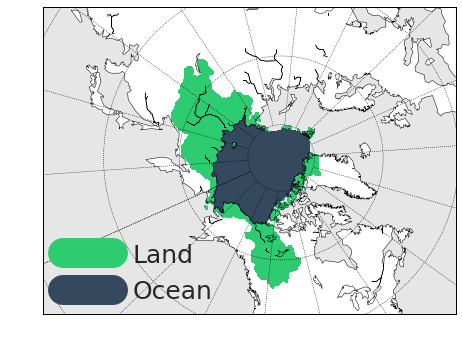

In [19]:
# lnd_mask_keys = ['mask_rof_to_centralarctic', 'mask_rof_to_kara', 'mask_rof_to_barents']

# lnd_mask = ncdata['rasm_lnd_masks'][lnd_mask_keys].to_array().sum(dim='variable')
# lnd_mask = lnd_mask.clip(0., 1.)

# ocn_mask_keys = ['mask_centralarctic', 'mask_kara', 'mask_barents']

# ocn_mask = ncdata['rasm_ocn_masks'][ocn_mask_keys].to_array().sum(dim='variable')
# ocn_mask = ocn_mask.clip(0., 1.)

# full_mask = lnd_mask + ocn_mask
# full_mask = full_mask.clip(0., 1.)

# all_ones_mask = full_mask.copy()
# all_ones_mask[:] = 1.
# else_mask = all_ones_mask - full_mask


sns.set_style("white")
fig, ax = plt.subplots()

wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=0.5)
wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=0.5)
wr50a_map.m.drawcoastlines(color='k', linewidth=0.5)
wr50a_map.m.drawmapboundary(fill_color=fill_color)
wr50a_map.m.fillcontinents(color='white', zorder=0)
wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi, 
                     np.ma.masked_where(ncdata['rasm_lnd_masks']['mask_rof_to_centralarctic'] <= 0,
                                        ncdata['rasm_lnd_masks']['mask_rof_to_centralarctic']),
                     colors=["#2ecc71", "#2ecc71"])
wr50a_map.m.contourf(wr50a_map.xi, wr50a_map.yi,
                     np.ma.masked_where(ncdata['rasm_ocn_masks']['mask_centralarctic'] <= 0,
                                        ncdata['rasm_ocn_masks']['mask_centralarctic']),
                     colors=["#34495e", "#34495e"])

# add legend
lines = []
labels = []
for source, color in zip(['Land', 'Ocean'], ["#2ecc71", "#34495e"]):
    lines.append(mlines.Line2D([], [], color=color, label=var, linewidth=30))
    labels.append(source)

leg = fig.legend(handles=lines, labels=labels, fontsize=25, loc=3, bbox_to_anchor=[0.07, 0.04])
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'arctic_flux_domain.pdf'), bbox_inches='tight')


In [20]:
def add_reservoir(center, dims, text, ax=None, fontsize=12):
    if ax is None:
        ax = plt.gca()
        
    x, y = center
    w, h = dims
        
    ax.add_patch(mpl.patches.Rectangle((x - w / 2., y - h / 2.), w, h, facecolor="white"))
    ax.text(x, y, text, fontsize=fontsize, fontweight='bold',
            horizontalalignment='center', verticalalignment='center')
    
    
annotate_kwargs = dict(xycoords='data', textcoords='data')


def arrow_kwargs(size):
    return dict(color="#34495e",
                length_includes_head=True,
                width=size,
                head_width=1.3 * size,
                head_length=1 * size)
    

In [21]:
df

,P_O,E_O,C_O,P_L,ET_L,R_L,C_L,C_A,dS_L
$RASM_{CONTROL}$,598.954241,204.756435,394.197805,1481.466257,46.690480,116.873071,1434.775776,1828.922406,1317.902706
$RASM_{RSI}$,617.955222,231.105290,386.849931,1497.489335,46.999874,118.747584,1450.489462,1837.288248,1331.741878
$RASM_{RSH}$,664.873843,310.422111,354.451732,1520.688080,46.438405,126.650110,1474.249675,1828.649654,1347.599565
era_monthly_ts3,741.173973,378.578498,362.595474,1565.753128,235.016486,848.043021,1330.736642,1693.284421,482.693621
merra_monthly_ts1,687.492238,6.933404,680.558834,1499.456511,210.109827,82.470422,1289.346684,1418.878232,1206.876262


## Timeseries of Water Budget Terms

In [22]:
depth_units = True

dsets = OrderedDict()
for dset in rasm_sims:
    ds = ncdata[dset]
    
    das = OrderedDict()
    
    for key, mask in [('serreze_land', lnd_mask), ('serreze_ocean', ocn_mask),
                      ('central_arctic_land', ncdata['rasm_lnd_masks']['mask_rof_to_centralarctic']),
                      ('central_arctic_ocean', ncdata['rasm_ocn_masks']['mask_centralarctic'])]:
        if depth_units:
            das[key] = ds[['Precipitation', 'Evaporation', 'Runoff']].where(mask).mean(dim=('x', 'y')).squeeze() * 86400
        else:
            das[key] = (ds[['Precipitation', 'Evaporation', 'Runoff']]
                * ncdata['rasm_domain']['area'] * mask).where(mask).sum(dim=('x', 'y')).squeeze()
            
        das[key] = das[key].resample('MS', how='mean', dim='time')
        
    dim = xr.DataArray(list(das.keys()), dims=('mask', ), name='mask')
    dsets[dset] = xr.concat(das.values(), dim=dim)

In [23]:
dim = xr.DataArray(list(dsets.keys()), dims=('dataset', ), name='dataset')
ds = xr.concat(xr.align(*list(dsets.values()), join='outer'), dim=dim)


In [24]:
ds.to_netcdf('../data/wb_depth_timeseries_by_mask.nc', mode='w')

In [25]:
ds.mean()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    *empty*
Data variables:
    Precipitation  float64 1.045
    Runoff         float64 0.593
    Evaporation    float64 -0.4734

In [26]:
ds.close()